### MFIN7034 Problem Set 2 – Risk Analysis

In [1]:
import os

data_path = "data"
if os.path.exists(data_path):
    os.chdir(data_path)
    print("current working directory: ", os.getcwd())
else:
    print("invalid data address")

current working directory:  /Users/Mike_Home/Desktop/MFIN7034 Machine Learning and Artificial Intelligence in Finance/HKU-MFIN7034-ML/data


In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# disable warnings
import warnings
warnings.filterwarnings("ignore")

In [55]:
credit_risk_df = pd.read_csv("credit_risk.csv")
credit_risk_df.head()

,default_label,age,gender,edu,housing,income,job_occupation,past_bad_credit,married
0,0,45,0,2,0,8756.330191,0,1,1
1,0,33,1,1,1,4762.472193,1,1,0
2,0,21,0,3,0,10944.838300,0,1,0
3,0,64,0,2,1,3957.592804,2,1,1
4,0,33,0,3,1,17820.791010,1,1,0


In [33]:
defualt_rate = len(credit_risk_df[credit_risk_df["default_label"] == 1]) / len(credit_risk_df) * 100
print(f"The default rate is {defualt_rate:.3f}%")

The default rate is 2.216%


In [34]:
credit_risk_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14262 entries, 0 to 14261
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   default_label    14262 non-null  int64  
 1   age              14262 non-null  int64  
 2   gender           14262 non-null  int64  
 3   edu              14262 non-null  int64  
 4   housing          14262 non-null  int64  
 5   income           14255 non-null  float64
 6   job_occupation   14262 non-null  int64  
 7   past_bad_credit  14262 non-null  int64  
 8   married          14262 non-null  int64  
dtypes: float64(1), int64(8)
memory usage: 1002.9 KB


In [35]:
credit_risk_df.describe()

,default_label,age,gender,edu,housing,income,job_occupation,past_bad_credit,married
count,14262.000000,14262.000000,14262.000000,14262.000000,14262.000000,1.425500e+04,14262.000000,14262.000000,14262.000000
mean,0.022157,46.566540,0.458701,1.695905,0.625789,1.233044e+04,0.336068,0.964591,0.525522
std,0.147198,221.030605,0.498309,1.101667,0.483936,2.214739e+05,0.557614,0.184817,0.499366
min,0.000000,17.000000,0.000000,0.000000,0.000000,6.504225e+02,0.000000,0.000000,0.000000
25%,0.000000,29.000000,0.000000,1.000000,0.000000,2.413715e+03,0.000000,1.000000,0.000000
50%,0.000000,42.000000,0.000000,2.000000,1.000000,5.565963e+03,0.000000,1.000000,1.000000
75%,0.000000,54.000000,1.000000,2.000000,1.000000,1.059000e+04,1.000000,1.000000,1.000000
max,1.000000,9999.000000,1.000000,4.000000,1.000000,9.999999e+06,2.000000,1.000000,1.000000


In [36]:
# print out the rows where there exists null values
credit_risk_df[credit_risk_df.isnull().any(axis=1)]

,default_label,age,gender,edu,housing,income,job_occupation,past_bad_credit,married
188,0,52,0,0,1,NaN,0,1,1
1263,0,37,0,1,1,NaN,1,1,1
8975,0,54,0,3,1,NaN,0,1,1
10725,0,23,0,1,1,NaN,0,1,1
10763,0,64,0,3,1,NaN,2,1,0
12171,0,58,1,2,1,NaN,0,1,1
13811,0,17,0,3,0,NaN,0,1,0


In [37]:
credit_risk_df.describe()

,default_label,age,gender,edu,housing,income,job_occupation,past_bad_credit,married
count,14262.000000,14262.000000,14262.000000,14262.000000,14262.000000,1.425500e+04,14262.000000,14262.000000,14262.000000
mean,0.022157,46.566540,0.458701,1.695905,0.625789,1.233044e+04,0.336068,0.964591,0.525522
std,0.147198,221.030605,0.498309,1.101667,0.483936,2.214739e+05,0.557614,0.184817,0.499366
min,0.000000,17.000000,0.000000,0.000000,0.000000,6.504225e+02,0.000000,0.000000,0.000000
25%,0.000000,29.000000,0.000000,1.000000,0.000000,2.413715e+03,0.000000,1.000000,0.000000
50%,0.000000,42.000000,0.000000,2.000000,1.000000,5.565963e+03,0.000000,1.000000,1.000000
75%,0.000000,54.000000,1.000000,2.000000,1.000000,1.059000e+04,1.000000,1.000000,1.000000
max,1.000000,9999.000000,1.000000,4.000000,1.000000,9.999999e+06,2.000000,1.000000,1.000000


#### 1.1 Logistic Model

In [38]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import sklearn.metrics as metrics

In [56]:
from sklearn.preprocessing import StandardScaler

credit_risk_processed_df = credit_risk_df.copy()

# 0. drop null values (income column)
credit_risk_processed_df.dropna(inplace=True)

# 1. log transform + quantile capping for income
credit_risk_processed_df["income"] = np.log(credit_risk_processed_df["income"])

# 3. handling categorical features - dummy variables
cat_features = ["edu", "job_occupation"]
credit_risk_processed_df = pd.get_dummies(credit_risk_processed_df, columns=cat_features)

# 4. handle age=9999 by filling with median age
median_age = credit_risk_processed_df.loc[credit_risk_processed_df['age'] != 9999, 'age'].median()
credit_risk_processed_df['age'] = credit_risk_processed_df['age'].replace(9999, median_age)

# 5. scaling
scale_cols = ["age", "income"]
scaler = StandardScaler()
credit_risk_processed_df[scale_cols] = scaler.fit_transform(credit_risk_processed_df[scale_cols])

# 6. feature engineering
credit_risk_processed_df["age_income_interaction"] = credit_risk_processed_df["age"] * credit_risk_processed_df["income"]
credit_risk_processed_df["income_per_age"] = credit_risk_processed_df["income"] / credit_risk_processed_df["age"]

In [57]:
credit_risk_processed_df.head()

,default_label,age,gender,housing,income,past_bad_credit,married,edu_0,edu_1,edu_2,edu_3,edu_4,job_occupation_0,job_occupation_1,job_occupation_2,age_income_interaction,income_per_age
0,0,0.228367,0,0,0.577867,1,1,False,False,True,False,False,True,False,False,0.131966,2.530428
1,0,-0.596702,1,1,-0.084678,1,0,False,True,False,False,False,False,True,False,0.050527,0.141910
2,0,-1.421771,0,0,0.820570,1,0,False,False,False,True,False,True,False,False,-1.166662,-0.577146
3,0,1.534727,0,1,-0.286083,1,1,False,False,True,False,False,False,False,True,-0.439059,-0.186406
4,0,-0.596702,0,1,1.350921,1,0,False,False,False,True,False,False,True,False,-0.806097,-2.263981


In [58]:
# define the feature columns and target column
def run_logistic_regression(features_df, target_series, model_name="", max_iter=1000, plot=True):
    X_train, X_test, y_train, y_test = train_test_split(
        features_df, target_series, test_size=0.3, random_state=42
    )
    
    # add class weight parameter to handle imbalance
    log_reg = LogisticRegression(class_weight="balanced", max_iter=max_iter)
    log_reg.fit(X_train, y_train)
    
    # get predicted probabilities for ROC curve
    y_proba = log_reg.predict_proba(X_test)[:, 1]
    
    # calculate evaluation metrics
    fpr, tpr, _ = metrics.roc_curve(y_test, y_proba)
    auc_score = metrics.roc_auc_score(y_test, y_proba)

    if plot:
        # run and compare models
        plt.figure(figsize=(10, 6))
        # plot ROC curve
        plt.plot(fpr, tpr, label=f"{model_name} (AUC = {auc_score:.3f})")
        plt.plot([0, 1], [0, 1], "k--")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("Logistic Regression ROC Curve")
        plt.legend(loc="lower right")
        plt.show()

    return (fpr, tpr, auc_score)

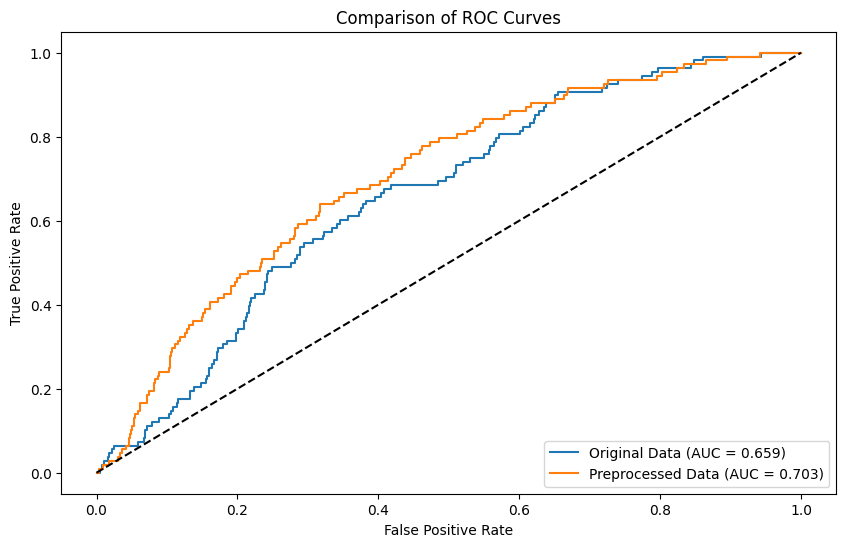

In [ ]:
# simple preprocess to make model run - drop null values
credit_risk_drop_na_df = credit_risk_df.copy()
credit_risk_drop_na_df.dropna(inplace=True)

fpr, tpr, auc_score = run_logistic_regression(
    credit_risk_drop_na_df.drop("default_label", axis=1),
    credit_risk_drop_na_df["default_label"],
    model_name="Original Data",
    plot=False
)

fpr2, tpr2, auc_score2 = run_logistic_regression(
    credit_risk_processed_df.drop("default_label", axis=1),
    credit_risk_processed_df["default_label"],
    model_name="Preprocessed Data",
    plot=False
)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f"Original Data (AUC = {auc_score:.3f})")
plt.plot(fpr2, tpr2, label=f"Preprocessed Data (AUC = {auc_score2:.3f})")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Comparison of ROC Curves")
plt.legend(loc="lower right")
plt.show()

#### 1.2.2 Random Forest

In [43]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_curve, auc

def run_random_forest(features_df, target_series, model_name="", plot=True):
    # use same train/test split for fair comparison
    X_train, X_test, y_train, y_test = train_test_split(
        features_df, target_series, test_size=0.3, random_state=42, stratify=target_series
    )
    
    # parameter grid for randomized search
    param_grid = {
        "n_estimators": [100, 200, 300],
        "max_depth": [None, 10, 20],
        "min_samples_split": [2, 5, 10],
        "max_features": ["sqrt", "log2", 0.5],
        "class_weight": ["balanced", "balanced_subsample"],
        "bootstrap": [True, False],
        "oob_score": [True],
        "min_samples_leaf": [1, 2, 4],
        "max_samples": [0.6, 0.8, None],
        "max_leaf_nodes": [None, 50, 100],
        "ccp_alpha": [0.0, 0.01, 0.1]
    }
    
    # initialize and tune RF model
    rf = RandomForestClassifier(random_state=42)
    search = RandomizedSearchCV(
        rf, param_grid, n_iter=30, scoring="roc_auc", 
        n_jobs=-1, cv=5, random_state=42
    )
    search.fit(X_train, y_train)
    
    # get best model
    best_rf = search.best_estimator_
    
    # get probabilities
    y_proba = best_rf.predict_proba(X_test)[:, 1]

    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc_score = auc(fpr, tpr)
    feature_importances = best_rf.feature_importances_
    
    if plot:
        # plot ROC curve
        plt.figure(figsize=(10, 6))
        plt.plot(fpr, tpr, label=f"{model_name} (AUC = {auc_score:.3f})")
        plt.plot([0, 1], [0, 1], "k--")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("Random Forest ROC Curve")
        plt.legend(loc="lower right")
        plt.show()
        
        # plot feature importances
        sorted_idx = feature_importances.argsort()[::-1]
        plt.figure(figsize=(10, 6))
        plt.bar(range(X_train.shape[1]), feature_importances[sorted_idx], align="center")
        plt.xticks(range(X_train.shape[1]), X_train.columns[sorted_idx], rotation=90)
        plt.xlabel("features")
        plt.ylabel("importance")
        plt.title("feature importance ranking")
        plt.tight_layout()
        plt.show()

    return best_rf

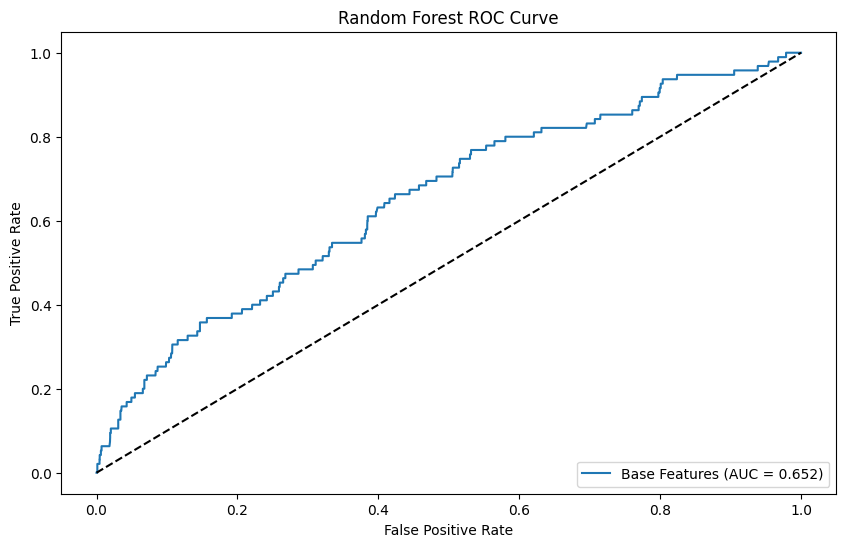

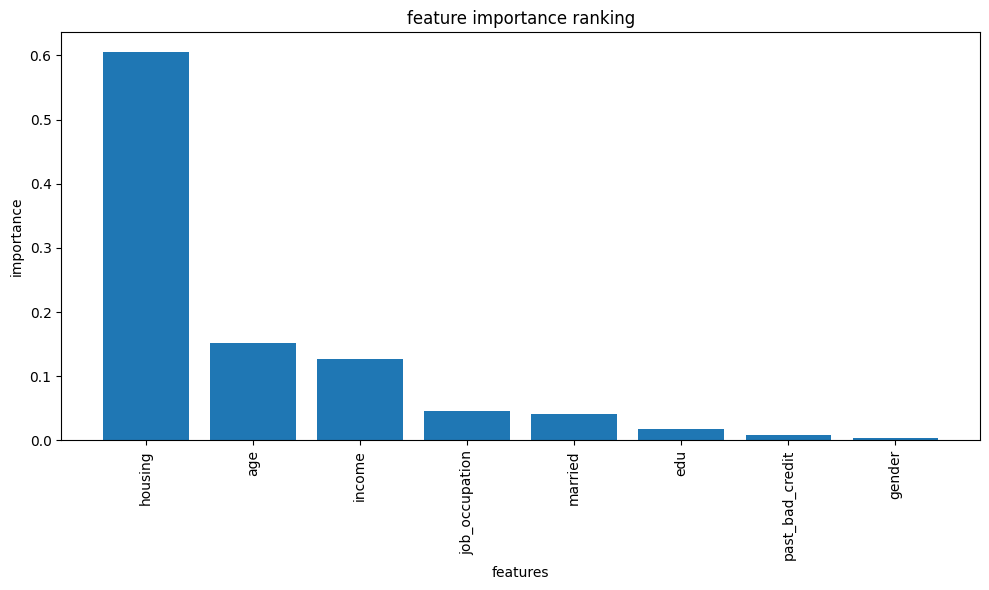

In [44]:
# run random forest with base features
best_rf = run_random_forest(
    credit_risk_drop_na_df.drop("default_label", axis=1),
    credit_risk_drop_na_df["default_label"],
    model_name="Base Features"
)

In [45]:
# print model parameters
from tabulate import tabulate

params = best_rf.get_params()
params_df = pd.DataFrame(list(params.items()), columns=["Parameter", "Value"])

print("Model Parameters:")
print(tabulate(params_df, headers="keys", tablefmt="grid", showindex=False))

Model Parameters:
+--------------------------+----------+
| Parameter                | Value    |
+==========================+==========+
| bootstrap                | True     |
+--------------------------+----------+
| ccp_alpha                | 0.01     |
+--------------------------+----------+
| class_weight             | balanced |
+--------------------------+----------+
| criterion                | gini     |
+--------------------------+----------+
| max_depth                | 20       |
+--------------------------+----------+
| max_features             | log2     |
+--------------------------+----------+
| max_leaf_nodes           | 100      |
+--------------------------+----------+
| max_samples              | 0.8      |
+--------------------------+----------+
| min_impurity_decrease    | 0.0      |
+--------------------------+----------+
| min_samples_leaf         | 1        |
+--------------------------+----------+
| min_samples_split        | 2        |
+---------------------

In [64]:
# pretty print feature importance
importances = best_rf.feature_importances_
sorted_idx = importances.argsort()[::-1]

rf_importance_df = pd.DataFrame({
    "Feature": credit_risk_df.drop("default_label", axis=1).columns[sorted_idx],
    "Importance": importances[sorted_idx]
})

print(tabulate(
    rf_importance_df,
    headers="keys",
    tablefmt="grid",
    showindex=False
))

+-----------------+--------------+
| Feature         |   Importance |
+=================+==============+
| housing         |   0.605593   |
+-----------------+--------------+
| age             |   0.150963   |
+-----------------+--------------+
| income          |   0.127342   |
+-----------------+--------------+
| job_occupation  |   0.0457172  |
+-----------------+--------------+
| married         |   0.0412001  |
+-----------------+--------------+
| edu             |   0.0179562  |
+-----------------+--------------+
| past_bad_credit |   0.00828422 |
+-----------------+--------------+
| gender          |   0.00294337 |
+-----------------+--------------+


#### 1.3 LightGBM

In [47]:
import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV

def run_lightgbm(features_df, target_series, model_name="", plot=True):
    
    # split data with stratification
    X_train, X_test, y_train, y_test = train_test_split(
        features_df, target_series, 
        test_size=0.3, 
        random_state=42, 
        stratify=target_series
    )
    
    # base parameters
    params = {
        "objective": "binary",
        "metric": "auc",
        "boosting_type": "gbdt",
        "verbosity": -1,
        "random_state": 42,
        "class_weight": "balanced",
        "deterministic": True,
        "max_cat_threshold": 32,
        "min_gain_to_split": 0.01,
        "path_smooth": 0.5
    }
    
    # hyperparameter search space
    param_grid = {
        "num_leaves": [15, 31, 63, 127],  # expanded range
        "learning_rate": [0.005, 0.01, 0.05, 0.1],  # added lower rate
        "subsample": [0.6, 0.7, 0.8, 0.9, 1.0],  # finer granularity
        "colsample_bytree": [0.6, 0.7, 0.8, 0.9, 1.0],
        "reg_alpha": [0, 0.01, 0.1, 1, 10],  # L1 range
        "reg_lambda": [0, 0.01, 0.1, 1, 10],  # L2 range
        "min_child_samples": [5, 10, 20, 50, 100],  # extended options
        "max_depth": [3, 5, 7, -1],  # -1=unlimited
        "path_smooth": [0, 0.1, 0.5],  # reduces overfitting
        "extra_trees": [True, False],  # extremely randomized trees
        "max_bin": [64, 128, 255],  # histogram bin counts
        "bagging_freq": [1, 5, 10],  # frequency for subsample
        "pos_bagging_fraction": [0.5, 0.7, 1.0],  # positive class subsampling
        "neg_bagging_fraction": [0.5, 0.7, 1.0],  # negative class subsampling
        "early_stopping_rounds": [None, 20, 40, 80]
    }
    
    # model tuning with early stopping
    gbm = lgb.LGBMClassifier(**params)
    search = RandomizedSearchCV(
        estimator=gbm,
        param_distributions=param_grid,
        n_iter=30,
        scoring="roc_auc",
        cv=5,
        n_jobs=-1,
        random_state=42
    )
    
    search.fit(
        X_train, y_train,
        eval_set=[(X_test, y_test)],
        eval_metric="auc",
    )
    
    # get best model
    best_gbm = search.best_estimator_
    y_proba = best_gbm.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc_score = auc(fpr, tpr)
    
    feature_importances = best_gbm.feature_importances_
    
    if plot:
        # plot ROC curve
        plt.figure(figsize=(10, 6))
        plt.plot(fpr, tpr, label=f"{model_name} (AUC = {auc_score:.3f})")
        plt.plot([0, 1], [0, 1], "k--")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("LightGBM ROC Curve")
        plt.legend(loc="lower right")
        plt.show()
        
        # plot feature importances
        sorted_idx = feature_importances.argsort()[::-1]
        feature_importances = feature_importances / feature_importances.sum()
        plt.figure(figsize=(10, 6))
        plt.bar(range(X_train.shape[1]), feature_importances[sorted_idx], align="center")
        plt.xticks(range(X_train.shape[1]), X_train.columns[sorted_idx], rotation=90)
        plt.xlabel("features")
        plt.ylabel("importance")
        plt.title("feature importance ranking")
        plt.tight_layout()
        plt.show()
    
    return auc_score, best_gbm

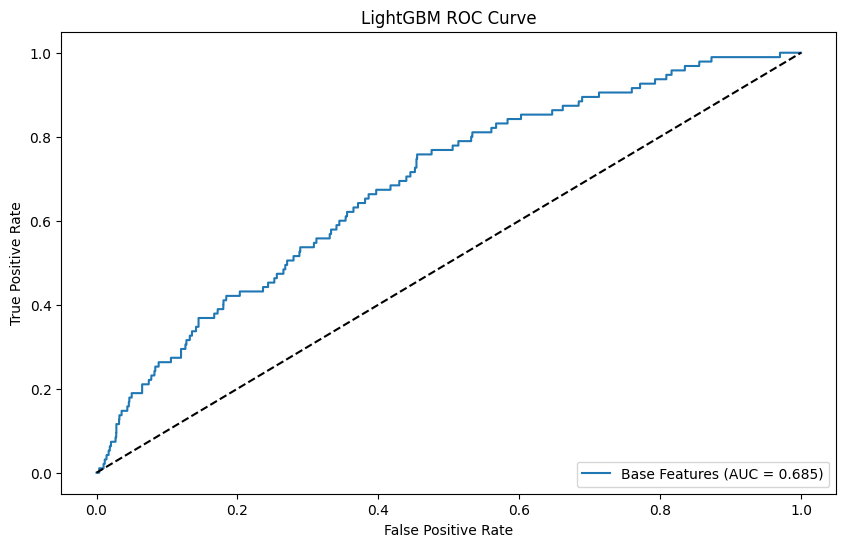

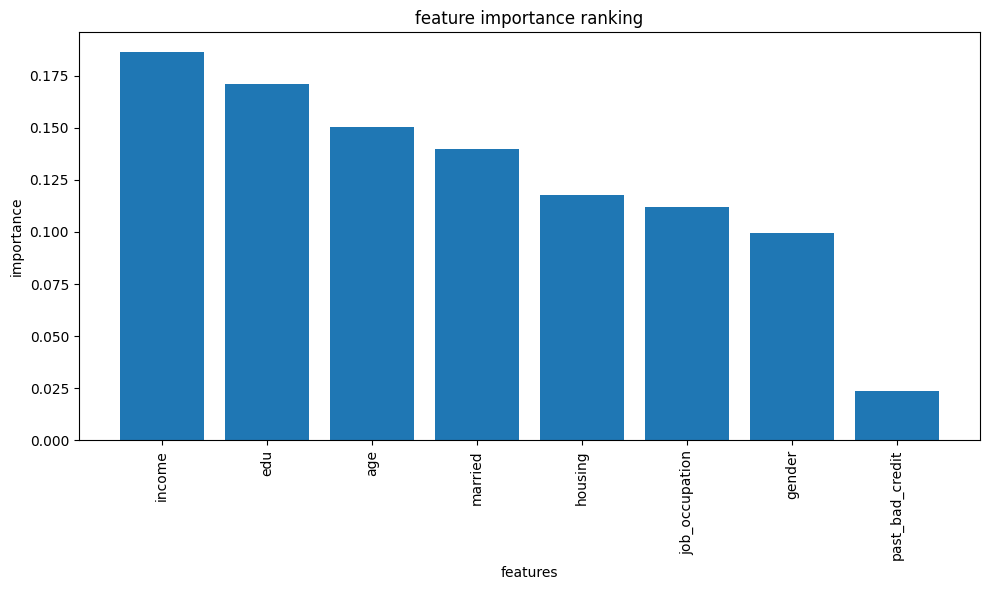

In [48]:
auc_gbm, best_gbm = run_lightgbm(
    credit_risk_df.drop("default_label", axis=1),
    credit_risk_df["default_label"],
    model_name="Base Features"
)

In [49]:
# pretty print best_gbm model parameters
params = best_gbm.get_params()
params_df = pd.DataFrame(list(params.items()), columns=["Parameter", "Value"])

print(tabulate(
    params_df,
    headers="keys",
    tablefmt="grid",
    showindex=False
))

+-----------------------+----------+
| Parameter             | Value    |
+=======================+==========+
| boosting_type         | gbdt     |
+-----------------------+----------+
| class_weight          | balanced |
+-----------------------+----------+
| colsample_bytree      | 1.0      |
+-----------------------+----------+
| importance_type       | split    |
+-----------------------+----------+
| learning_rate         | 0.1      |
+-----------------------+----------+
| max_depth             | -1       |
+-----------------------+----------+
| min_child_samples     | 100      |
+-----------------------+----------+
| min_child_weight      | 0.001    |
+-----------------------+----------+
| min_split_gain        | 0.0      |
+-----------------------+----------+
| n_estimators          | 100      |
+-----------------------+----------+
| n_jobs                |          |
+-----------------------+----------+
| num_leaves            | 15       |
+-----------------------+----------+
|

In [65]:
# pretty print
# normalise feature_importance_gbm so that all elements sum to one
feature_importance_gbm = best_gbm.feature_importances_
feature_importance_gbm = feature_importance_gbm / feature_importance_gbm.sum()

sorted_idx = feature_importance_gbm.argsort()[::-1]
gbm_importance_df = pd.DataFrame({
    "Feature": credit_risk_df.drop("default_label", axis=1).columns[sorted_idx],
    "Importance": feature_importance_gbm[sorted_idx]
})

print(tabulate(
    gbm_importance_df,
    headers="keys",
    tablefmt="grid",
    showindex=False
))

+-----------------+--------------+
| Feature         |   Importance |
+=================+==============+
| income          |    0.186424  |
+-----------------+--------------+
| edu             |    0.171128  |
+-----------------+--------------+
| age             |    0.150096  |
+-----------------+--------------+
| married         |    0.139579  |
+-----------------+--------------+
| housing         |    0.117591  |
+-----------------+--------------+
| job_occupation  |    0.111855  |
+-----------------+--------------+
| gender          |    0.0994264 |
+-----------------+--------------+
| past_bad_credit |    0.0239006 |
+-----------------+--------------+


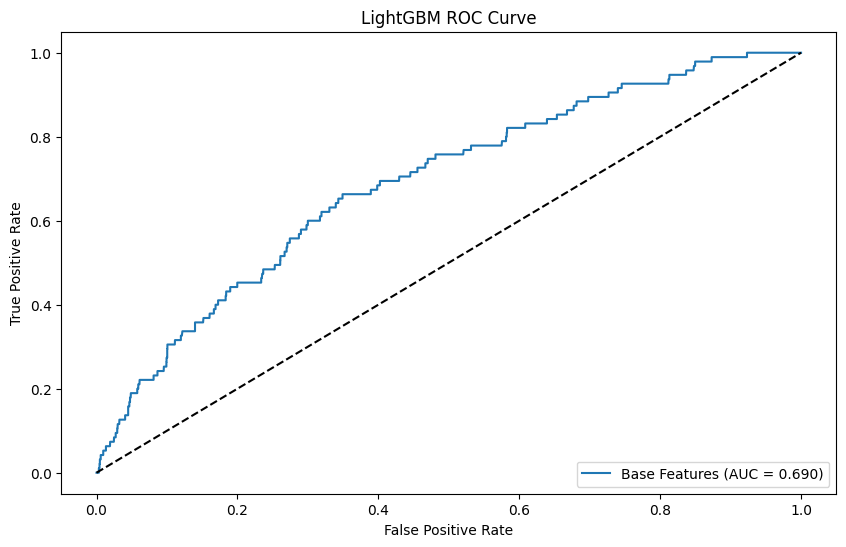

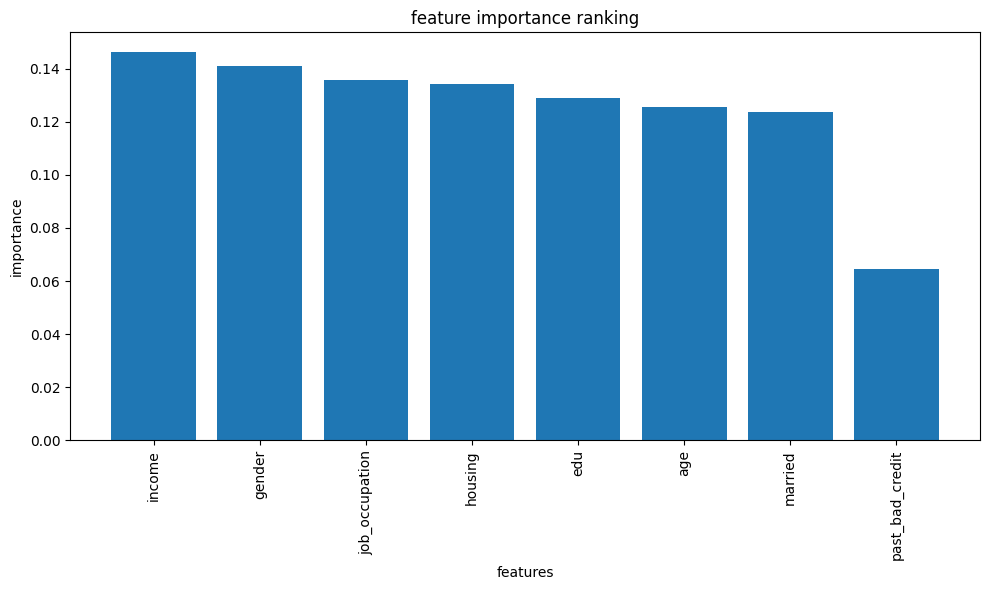

In [51]:
# handle age=9999 by filling with median age
credit_risk_processed_df = credit_risk_df.copy()
median_age = credit_risk_processed_df.loc[credit_risk_processed_df['age'] != 9999, 'age'].median()
credit_risk_processed_df['age'] = credit_risk_processed_df['age'].replace(9999, median_age)

_ = run_lightgbm(
    credit_risk_processed_df.drop("default_label", axis=1),
    credit_risk_processed_df["default_label"],
    model_name="Base Features"
)

#### 2.1 Data Preprocessing

At first glance, we noticed some issues to the original data. First of all, we notice some there are some missing value in the "income" column. Then we noticed that the maximum value for the "age" column is 9999, which is unrealistic. On a closer inspection, we noticed that the value for ``income" is skewed, there exist extreme values.

##### For Logistic Regression Model
First we drop the rows with missing "income". The other option is that we fill the missing values with some imputer, for example, we can fill the missing income values with median income in the dataset. However, as shown earlier, "income" is one of the most important features, we do not want to perform inappropriate data filling. There exists some extreme values in the "income" column, we need to compress them by taking logarithm. This allows the linear models to better capture non-linear effects. We choose to fill the 9999 age rows with median age. Both "age" and "income" need to be standardized. Then we need to handle categorical features, including "edu" and "job\_occupation". We perform one-hot encoding by introduce dummy variables to categorical features. Although "gender", "housing" etc. are also categorical, the values for them are either 0 or 1, there is no need for one-hot encoding. Finally we perform feature engineering by adding some age-income interaction (because they are the only numeric features, other features are categorical).

##### For LightGBM Model
LightGBM handles categorical features and missing values differently. For example, LightGBM can handle categorical features natively, instead, using one-hot encoding for LightGBM could lead to high dimensionality and less efficient training. Also, scaling features isn't necessary for tree-based models like LightGBM and Random Forest because they split on feature values regardless of their scale. They can capture non-linear relationships, so polynomial features or interaction terms are not needed. Additionally, LighGBM can handle missing values automatically by considering them as a separate category or directions in splits, we could potentially lose information if we imputed missing values. Just to compare, we ran LightGBM using the original data, the AUC we got is 0.685. Then we ran the LightGBM with age=9999 replaced with median value, the AUC is 0.690. Performance is improved but minor.

#### 2.2 Feature Importance Analysis

In [72]:
credit_risk_drop_na_df = credit_risk_df.copy()
credit_risk_drop_na_df.dropna(inplace=True)

features_df = credit_risk_drop_na_df.drop("default_label", axis=1)
target_series = credit_risk_drop_na_df["default_label"]

# 1. For Logistic Regression Model
X_train, X_test, y_train, y_test = train_test_split(
    features_df, target_series, test_size=0.3, random_state=42
)

# add class weight parameter to handle imbalance
log_reg = LogisticRegression(class_weight="balanced", max_iter=100)
log_reg.fit(X_train, y_train)

# get feature importance
feature_importance = abs(log_reg.coef_[0])
log_importance_df = pd.DataFrame({
    "Feature": features_df.columns,
    "Importance": feature_importance
}).sort_values(by="Importance", ascending=False)

# display feature importance
print("Logistic Regression Feature Importance:")
print(tabulate(
    log_importance_df,
    headers="keys",
    tablefmt="grid",
    showindex=False
))


Logistic Regression Feature Importance:
+-----------------+--------------+
| Feature         |   Importance |
+=================+==============+
| housing         |  0.909625    |
+-----------------+--------------+
| job_occupation  |  0.394861    |
+-----------------+--------------+
| past_bad_credit |  0.373289    |
+-----------------+--------------+
| gender          |  0.237801    |
+-----------------+--------------+
| edu             |  0.0497913   |
+-----------------+--------------+
| married         |  0.00461426  |
+-----------------+--------------+
| age             |  0.000964045 |
+-----------------+--------------+
| income          |  1.83683e-07 |
+-----------------+--------------+


In [ ]:
print("Random Forest Feature Importance:")
print(tabulate(
    rf_importance_df,
    headers="keys",
    tablefmt="grid",
    showindex=False
))

In [70]:
print("LightGBM Feature Importance:")
print(tabulate(
    gbm_importance_df,
    headers="keys",
    tablefmt="grid",
    showindex=False
))

LightGBM Feature Importance:
+-----------------+--------------+
| Feature         |   Importance |
+=================+==============+
| income          |    0.186424  |
+-----------------+--------------+
| edu             |    0.171128  |
+-----------------+--------------+
| age             |    0.150096  |
+-----------------+--------------+
| married         |    0.139579  |
+-----------------+--------------+
| housing         |    0.117591  |
+-----------------+--------------+
| job_occupation  |    0.111855  |
+-----------------+--------------+
| gender          |    0.0994264 |
+-----------------+--------------+
| past_bad_credit |    0.0239006 |
+-----------------+--------------+


In [76]:
# 1. Get top 5 features from each model
log_top5 = log_importance_df.head(5)['Feature'].tolist()
rf_top5 = rf_importance_df.head(5)['Feature'].tolist()
lgb_top5 = gbm_importance_df.head(5)['Feature'].tolist()

# 2. Create comparison dataframe
rank_df = pd.DataFrame({
    'Ranking': ['1st', '2nd', '3rd', '4th', '5th'],
    'Logistic Regression': log_top5,
    'Random Forest': rf_top5,
    'LightGBM': lgb_top5
}).set_index('Ranking')

# 3. Display formatted table
print(tabulate(
    rank_df,
    headers='keys',
    tablefmt='grid',
    stralign='left'
))

+-----------+-----------------------+-----------------+------------+
| Ranking   | Logistic Regression   | Random Forest   | LightGBM   |
+===========+=======================+=================+============+
| 1st       | housing               | housing         | income     |
+-----------+-----------------------+-----------------+------------+
| 2nd       | job_occupation        | age             | edu        |
+-----------+-----------------------+-----------------+------------+
| 3rd       | past_bad_credit       | income          | age        |
+-----------+-----------------------+-----------------+------------+
| 4th       | gender                | job_occupation  | married    |
+-----------+-----------------------+-----------------+------------+
| 5th       | edu                   | married         | housing    |
+-----------+-----------------------+-----------------+------------+


#### 2.3 Go Deeper towards Feature Importance Analysis! 

In [83]:
from sklearn.inspection import permutation_importance

def get_unified_importance(model, X, y, metric='roc_auc'):
    # calculate permutation importance
    result = permutation_importance(
        model, X, y,
        n_repeats=30,  # 30 shuffles for stability
        random_state=42,
        scoring=metric
    )
    
    # create importance dataframe
    importance_df = pd.DataFrame({
        'Feature': X.columns,
        'Importance': result.importances_mean,
    }).sort_values('Importance', ascending=False)
    
    return importance_df

In [84]:
# For all models
models = [log_reg, best_rf, best_gbm]
unified_importances = [get_unified_importance(m, X_test, y_test) for m in models]

# Combine results
combined_df = pd.concat([
    imp_df.assign(Model=type(m).__name__) 
    for m, imp_df in zip(models, unified_importances)
])

In [87]:
print(tabulate(
    combined_df,
    headers='keys',
    tablefmt='grid',
    stralign='left'
))

+----+-----------------+--------------+------------------------+
|    | Feature         |   Importance | Model                  |
+====+=================+==============+========================+
|  3 | housing         |  0.112001    | LogisticRegression     |
+----+-----------------+--------------+------------------------+
|  5 | job_occupation  |  0.0276923   | LogisticRegression     |
+----+-----------------+--------------+------------------------+
|  6 | past_bad_credit |  0.00755251  | LogisticRegression     |
+----+-----------------+--------------+------------------------+
|  7 | married         |  0.000372162 | LogisticRegression     |
+----+-----------------+--------------+------------------------+
|  2 | edu             |  0.000307235 | LogisticRegression     |
+----+-----------------+--------------+------------------------+
|  4 | income          | -0.000319895 | LogisticRegression     |
+----+-----------------+--------------+------------------------+
|  0 | age             | 